# 深層学習を使った自然言語処理モデル
1. 分散表現 : 文・単語・文字等を、低次元(100〜1000次元くらい)のベクトルで表現
2. Attentionと呼ばれる、複数個の入力の内、どこを注目すべきか学習するモデル

[Attention Is All You Need](https://arxiv.org/abs/1706.03762)

# 単語の分散表現が抱えている課題
- 単語の曖昧性を考慮できていない。

# 量子自然言語処理ソフトウェア Lambeq
Lambeqは、量子自然言語処理（QNLP）のために開発されたPythonライブラリで、Cambridge QuantumのQNLPチームによって作成されたものです。
このライブラリは、与えられたモデルやパラメータ設定、ansatzeの選択に基づいて、あらゆる文章を量子回路に変換することができ、量子および古典NLPのための訓練が容易にできます。
- Lambeqのドキュメントページは[こちら](https://cqcl.github.io/lambeq/index.html)です。
- 最新リリースのノートは[こちら](https://cqcl.github.io/lambeq/release_notes.html#sec-release-notes)です。

lambeq は Python3.8, 3.9をサポートしています. 

In [ ]:
# Lambeqのインストール
#pip install lambeq

# Syntax-based model: DisCoCat

DisCoCatの出力を得るために、構文解析器BobcatParserクラスを使って、文のCCG (Combinatory Categorial Grammar) 導出を得て、それを図に変換する。

以下では、文"John walks in the park "の図を生成するために、デフォルトの構文解析器BobcatParserを利用する。


/opt/conda/lib/python3.9/site-packages/lambeq/ccg2discocat/ccg_parser.py:23: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


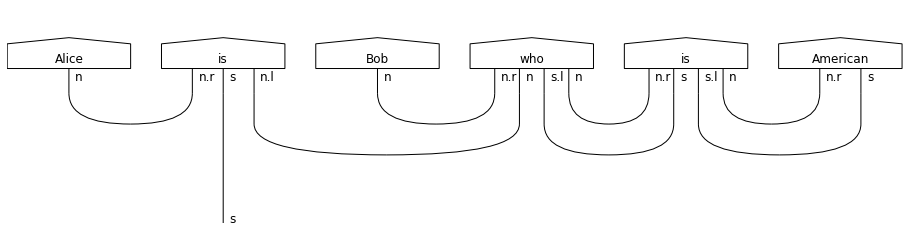

In [1]:
from lambeq import BobcatParser
from discopy import grammar

sentence = 'Alice is Bob who is American'

# Parse the sentence and convert it into a string diagram
#parser = BobcatParser(verbose='suppress')
#parser = BobcatParser(verbose='progress')
parser = BobcatParser()
diagram = parser.sentence2diagram(sentence)

grammar.draw(diagram, figsize=(14,3), fontsize=12)

# Bag-of-words: Spiders reader

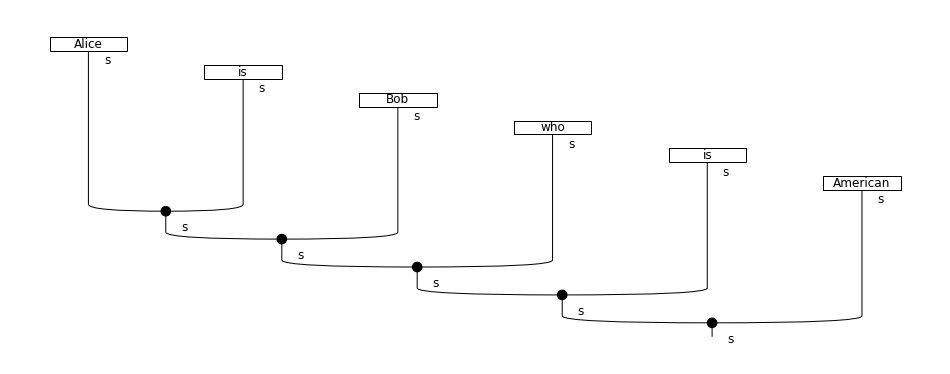

In [2]:
from lambeq import spiders_reader

# Create string diagrams based on spiders reader
spiders_diagram = spiders_reader.sentence2diagram(sentence)

# Not a pregroup diagram, we can't use grammar.draw()
spiders_diagram.draw(figsize=(13,5), fontsize=12)

# Word-sequence models: Cups and stairs readers
LinearReaderクラスは、単語が左から右へ順番に構成されるあらゆる種類のモデルを作成するのに使用できる。
このクラスのcups_readerインスタンスは「テンソル列」を生成する。

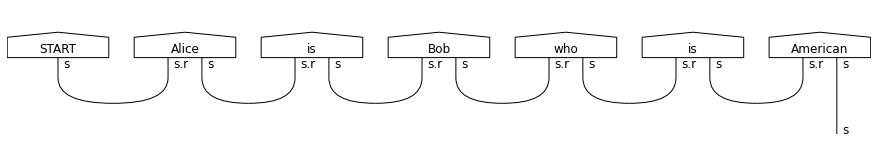

In [3]:
from lambeq import cups_reader

# Create string diagrams based on cups reader
cups_diagram = cups_reader.sentence2diagram(sentence)

grammar.draw(cups_diagram, figsize=(12,3), fontsize=12)

文頭のSTARTは次数1のテンソル（ベクトル）として表現。
計算の最終結果（つまり文の表現）が次数1のテンソルになる。

もう一つの既成の単語列モデルは stairs_reader のインスタンスによって提供される。このモデルはリカレントニューラルネットワークと同様に、ボックス（「セル」）を用いて連続する単語を再帰的に結合する。

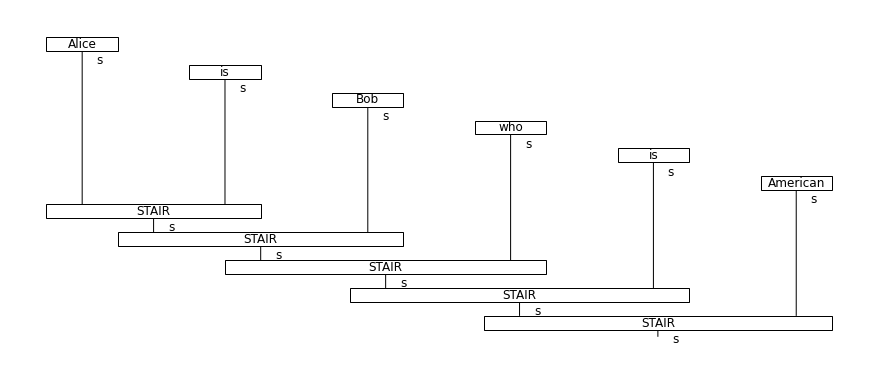

In [4]:
from lambeq import stairs_reader

stairs_diagram = stairs_reader.sentence2diagram(sentence)
stairs_diagram.draw(figsize=(12,5), fontsize=12)

# Tree readers
クラスTreeReaderでは、CCG (Combinatory Categorial Grammar) の導出は前群形式への変換なしに，一連のコンポジションとして直接解釈することができる。

CCG構文の詳細を知らなくても、
1. 動詞「give」が間接目的語「Mary」と合成され、
2. それが直接目的語に対応する名詞句「a flower」と合成され、
3. 最後に動詞句全体「give Mary a flower」が主語「John」とさらに合成されて文章が返される

TreeReaderは、この構成順序にしたがって、以下のような処理を行う。

In [ ]:
from lambeq import TreeReader

reader = TreeReader()
sentence = "John gave Mary a flower"

tree_diagram = reader.sentence2diagram(sentence)
tree_diagram.draw(figsize=(12,5), fontsize=12)

デフォルトでは、合成はUNIBOXという名前の単一の「セル」によって処理されることに注意

オプション
- NO_TYPE：デフォルト、すべての合成は同じUNIBOXセルで処理。
- RULE_ONLY：各CCGルールに対して異なるセルを作成。
- RULE_TYPE：(ルール、タイプ)のペアごとに異なるセルを作成。

/opt/conda/lib/python3.9/site-packages/lambeq/ccg2discocat/ccg_parser.py:23: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


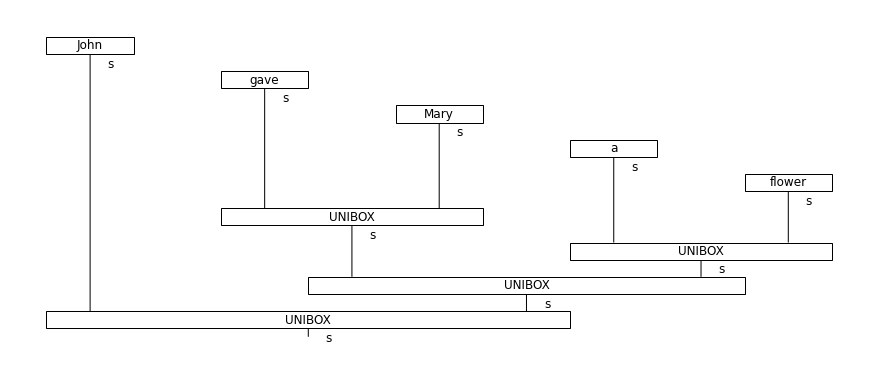

In [1]:
from lambeq import TreeReader, TreeReaderMode

reader = TreeReader(mode=TreeReaderMode.NO_TYPE)
#reader = TreeReader(mode=TreeReaderMode.RULE_ONLY)
#reader = TreeReader(mode=TreeReaderMode.RULE_TYPE)
sentence = "John gave Mary a flower"

tree_diagram = reader.sentence2diagram(sentence)
tree_diagram.draw(figsize=(12,5), fontsize=12)

上記では、CCG独自のルールにそれぞれボックスを設けている。
FAボックスは前方への適用に、BAボックスは後方への適用に対応。
ある種のタスクでは、合成ボックスのルールを固有にすることで、より良い汎化および良い性能につながるかもしれない。

# Step 2. Diagram rewriting
前群での構文導出は非常に複雑になるため、ハードウェアリソースの過剰使用や学習時間の長さにつながる可能性があります。
rewriteモジュールの目的は、文字列図を単純化する書き換えルールによって、これらの問題のいくつかに対処する手段をユーザーに提供することである。

"John walks in the park "という文をもう一度考えてみる。

/opt/conda/lib/python3.9/site-packages/lambeq/ccg2discocat/ccg_parser.py:23: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


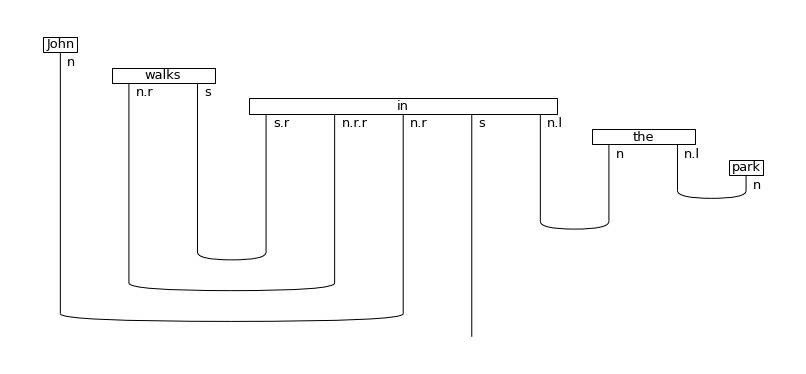

In [1]:
from lambeq import BobcatParser

# Parse the sentence
parser = BobcatParser(verbose='suppress')
diagram = parser.sentence2diagram("John walks in the park")

diagram.draw(figsize=(11,5), fontsize=13)

前置詞の表現は、「古典」の場合は次数5のテンソル、「量子」の場合は5つの量子系の状態である。
- 前置詞の書き換え規則を適用すると、モノイダル構造（モノイド：積構造＋単位元存在（逆元存在しない））を利用することができる。
- 前置詞を通じて繋がっていた名詞を、キャップで直接つなぐことが可能。
- 前置詞の書き換え規則を適応すると冠詞「the」を排除。

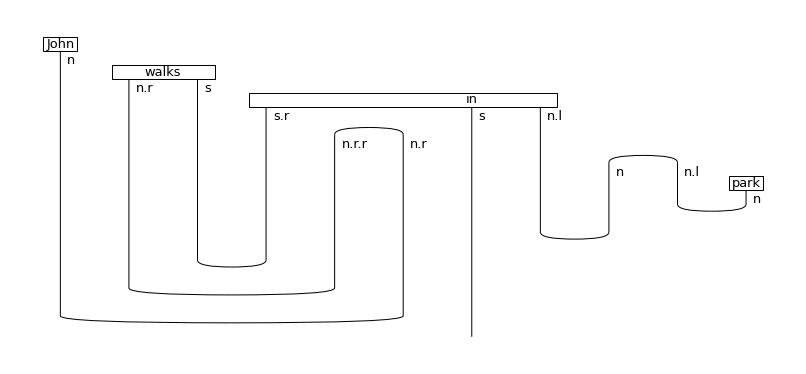

In [2]:
from lambeq import Rewriter

# Apply rewrite rule for prepositional phrases

rewriter = Rewriter(['prepositional_phrase', 'determiner'])
rewritten_diagram = rewriter(diagram)

rewritten_diagram.draw(figsize=(11,5), fontsize=13)

Lambeqは配線を引き伸ばし、必要に応じてボックスの配置を変えて、図を書き換えることができる。

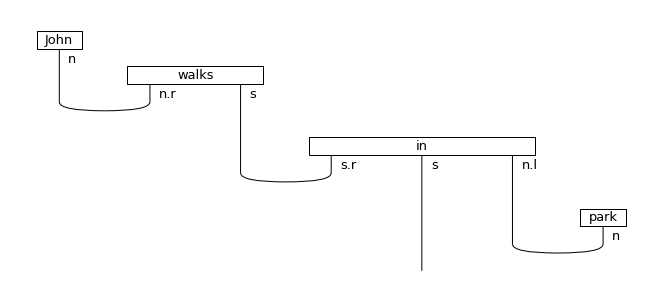

In [3]:
normalised_diagram = rewritten_diagram.normal_form()
normalised_diagram.draw(figsize=(9,4), fontsize=13)

# Step 3. Parameterisation Classical case
- ここまでは、文を図として表現しただけで、テンソル次元や量子ゲートの選択の決定とは無関係。
- Ansatzを適用することにより、具体的な量子回路やテンソルネットワークに変換することが可能。
- Ansatzは、図の各ワイヤーが関連する量子ビットの数や、各ワードに対応する具体的な量子状態を決定するマップと見なすことが可能。
- lambeqでは、実験の種類に応じてTensorAnsatzまたはCircuitAnsatzクラスのいずれかを拡張することでAnsatzeを追加することが可能。

- 簡略化した図では、前置詞に対応するテンソルの次数が2つ減っており、少なくとも古典的な実験ではかなりの改善。
- 冠詞が削除され、「the park」が「park」という名詞の意味と等しくなっている。
- 単純なテンソルネットワークと比較して図の柔軟性を明確に示しており、これがlambeqの表現形式として選んだ主な理由の1つである。
- lambeqには、助動詞、接続詞、副詞、冠詞、関係代名詞、前置詞をカバーする多くの標準書き換え規則が付属。

| Rewrite rule | Description |
|---|---|
|auxiliary|Removes auxiliary verbs (such as “do”) by replacing them with caps.|
|connector|Removes sentence connectors (such as “that”) by replacing them with caps.|
|coordination|Simplifies “and” by replacing it with a layer of interleaving spiders.|
|determiner|Removes determiners (such as “the”) by replacing them with caps.|
|object_rel_pronoun<br>subject_rel_pronoun|Simplifies relative pronouns (such as “that”) using cups, spiders and a loop.|
|postadverb<br>preadverb|Simplifies adverbs by passing through the noun wire transparently using a cap.
|prepositional_phrase|Simplifies prepositions by passing through the noun wire using a cap.

# Parameterisation: Classical case
- 古典の場合、テンソルansatzの一つをインスタンス化するには、図に出現するタイプのそれぞれに次元を割り当てることが必要である。
- 名詞空間の基本次元と文空間の次元をテンソルAnsatzのインスタンスにパラメータとして与えている。

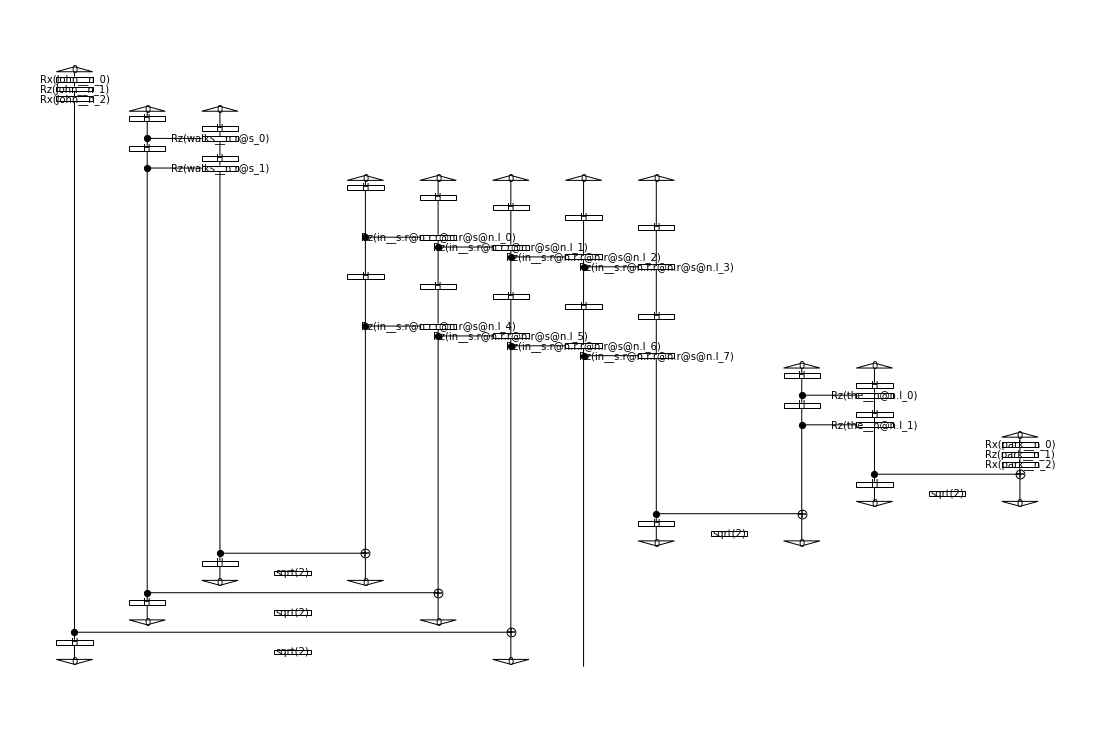

In [13]:
from lambeq import AtomicType, IQPAnsatz

# Define atomic types
N = AtomicType.NOUN
S = AtomicType.SENTENCE

# Convert string diagram to quantum circuit
ansatz = IQPAnsatz({N: 1, S: 1}, n_layers=2)
discopy_circuit = ansatz(diagram)
#discopy_circuit = ansatz(normalised_diagram)
discopy_circuit.draw(figsize=(15,10))

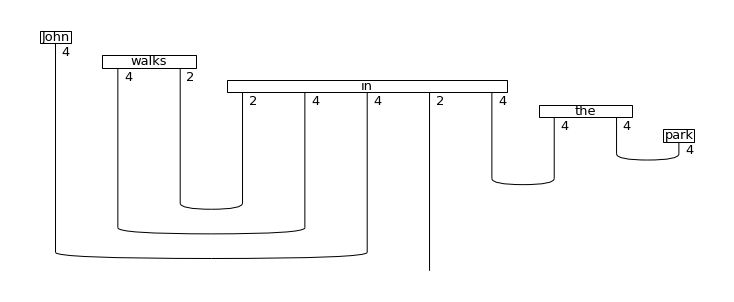

In [14]:
from lambeq import TensorAnsatz
from discopy import Dim

tensor_ansatz = TensorAnsatz({N: Dim(4), S: Dim(2)})
tensor_diagram = tensor_ansatz(diagram)
#tensor_diagram = tensor_ansatz(normalised_diagram)

tensor_diagram.draw(figsize=(10,4), fontsize=13)

# Matrix product states
- 古典では、接続詞など特定の単語に関連するテンソルが非常に大きくなることがある。
- 場合によっては、テンソルの次数は12あるいはそれ以上（要素、ここで基底次元）にもなり、効率的な実験の実行は不可能である。
- この問題に対処するため、lambeq はテンソルを様々な形式の行列積状態 (MPS) に変換するための ansatze を備えている。

以下のコードは、2以上の次数を持つテンソルをスパイダーで連結した次数2のテンソル（つまり行列）の列に分割するSpiderAnsatzを適用したものである。

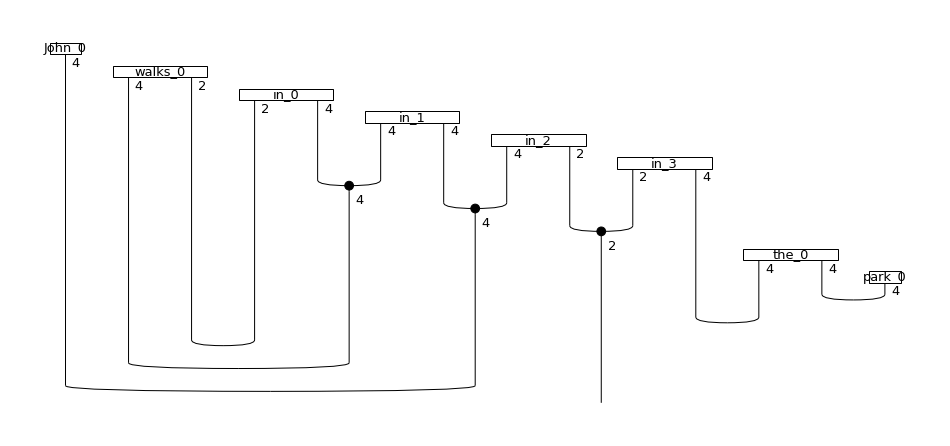

In [15]:
from lambeq import SpiderAnsatz
from discopy import Dim

spider_ansatz = SpiderAnsatz({N: Dim(4), S: Dim(2)})
spider_diagram = spider_ansatz(diagram)
#spider_diagram = spider_ansatz(normalised_diagram)
spider_diagram.draw(figsize=(13,6), fontsize=13)

前置詞「in」が4つの行列を連結した行列積の状態で表現されるようになり、テンソルの保存に必要な容量が非常に小さくなる。

Another option is the MPSAnsatz class, which converts large tensors to sequences of order-3 tensors connected with cups. In this setting, the user needs to also define the bond dimension, that is, the dimensionality of the wire that connects the tensors together.
もう一つの選択肢は MPSAnsatz クラスで、これはカップで接続された次数3のテンソルの列に変換する。
このMPSAnsatz クラスの設定では、結合次元（テンソル同士をつなぐワイヤの次元）も定義する必要がある。

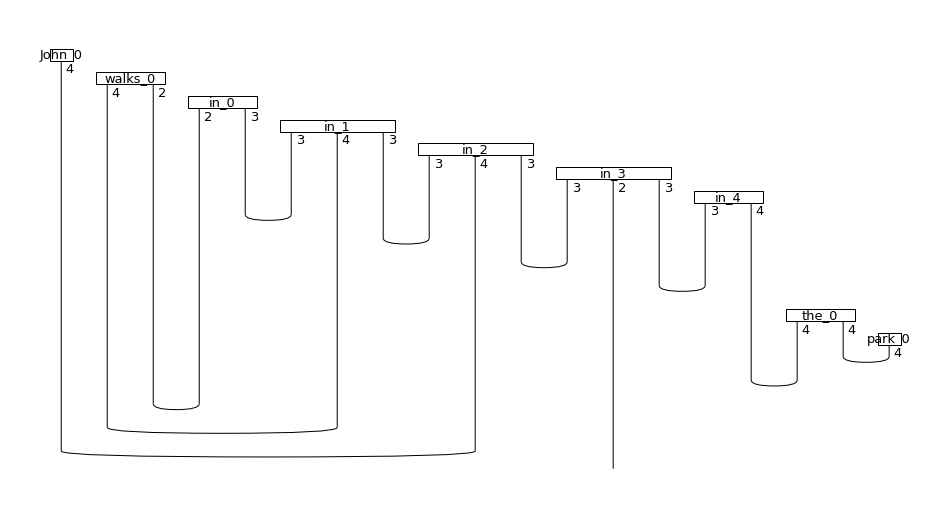

In [18]:
from lambeq import MPSAnsatz
from discopy import Dim

mps_ansatz = MPSAnsatz({N: Dim(4), S: Dim(2)}, bond_dim=3)
mps_diagram = mps_ansatz(diagram)
#mps_diagram = mps_ansatz(normalised_diagram)
mps_diagram.draw(figsize=(13,7), fontsize=13)

# Step 4: Training Classical case
lambeqでは、学習時に行われる処理はすべて学習パッケージに組み込まれており、古典および量子のツールキットを用いた教師あり学習を提供します。

具体的には，トレーニングパッケージは以下の具体的な実装を含んでいます．
- Dataset: 選択したバックエンド（tket、NumPy、PyTorch）に基づき、バッチ処理、シャッフル、準備など、データセットを簡単に管理・操作するための機能を提供する。
- Model: lambeqモデルの抽象的なインターフェース。モデルは、特定のバックエンドが与えられた場合に、学習に使用する基本的な属性とメソッドを操作する。具体的な実装としては、PytorchModel、TketModel、NumpyModelがある。
- Optimizer: lambeqオプティマイザは、モデルのパラメータに関して与えられた損失関数の勾配を計算する。SPSAOptimizerクラスで実装されたSPSAアルゴリズムをサポートしている。
- Trainer: lambeqにおける教師あり学習の主要なインタフェース。トレーナーは、損失関数とオプティマイザを用いて、特定のバックエンドで（量子）機械学習ルーチンを実装する。具体的な実装としては、PytorchTrainerとQuantumTrainerがある。

モデルの学習は、次のような手順で行われる。
1. Mode:のインスタンスを作成する。
2. Trainerのインスタンスを作成し、モデル、損失関数、オプティマイザーを渡す。
3. 学習用のデータセットと、オプションで評価用のデータセットを作成する。
4. データセットをTrainerのfit()メソッドに渡すことで、モデルを学習させる。

以下の章では、古典的な学習シナリオと量子的な学習シナリオについて、学習パッケージの使用方法を説明する。

# Training: Classical case
意味分類データセットに古典的なパイプラインを実装した、lambeqの学習モジュールのユースケースを紹介する。
目標は、単純な文（「熟練したプログラマーがソフトウェアを作る」や「シェフがおいしい食事を作る」など）を、食べ物の文かITの文かの2つのカテゴリに分類すること。

データセットは130文からなる。

## Preparation
PyTorchのインポートとハイパーパラメータの設定.

In [1]:
import torch

BATCH_SIZE = 30
EPOCHS = 30
LEARNING_RATE = 3e-2
SEED = 0

## Input data
トレーニングデータの読み込み（料理の文：(1,0), プログラミングの文:(0,1)）

In [2]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('./Lambeq/examples/datasets/mc_train_data.txt')
val_labels, val_data = read_data('./Lambeq/examples/datasets/mc_dev_data.txt')
test_labels, test_data = read_data('./Lambeq/examples/datasets/mc_test_data.txt')

### Train data

In [3]:
train_data[:5]

['skillful man prepares sauce .',
 'skillful man bakes dinner .',
 'woman cooks tasty meal .',
 'man prepares meal .',
 'skillful woman debugs program .']

### Targets are represented as 2-dimensional arrays:

In [4]:
train_labels[:5]

[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0]]

## Creating and parameterising diagrams
文から図に変換

In [5]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

train_diagrams = parser.sentences2diagrams(train_data)
val_diagrams = parser.sentences2diagrams(val_data)
test_diagrams = parser.sentences2diagrams(test_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


生成された図は、特定のansatzによってパラメータ化される必要がある。ここでは、SpiderAnsatzを使用する。

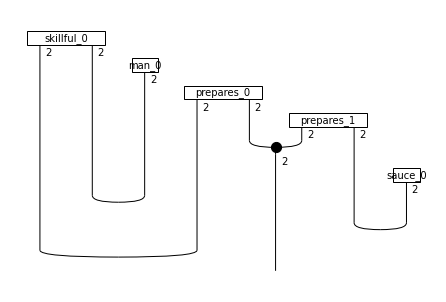

In [6]:
from discopy import Dim

from lambeq import AtomicType, SpiderAnsatz

ansatz = SpiderAnsatz({AtomicType.NOUN: Dim(2),
                       AtomicType.SENTENCE: Dim(2)})

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
val_circuits =  [ansatz(diagram) for diagram in val_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw()

# Instantiate the model
PytorchModelクラスをインポートし、クラスメソッドPytorchModel.from_diagrams()にすべての図を渡すことで、モデルの初期値を設定する。

In [7]:
from lambeq import PytorchModel

all_circuits = train_circuits + val_circuits + test_circuits
model = PytorchModel.from_diagrams(all_circuits)

# Define evaluation metric
オプションとして、以下のように評価指標を設定することが可能。

In [8]:
sig = torch.sigmoid

def accuracy(y_hat, y):
    return torch.sum(torch.eq(torch.round(sig(y_hat)), y))/len(y)/2  # half due to double-counting

eval_metrics = {"acc": accuracy}


# Initialise trainer
PytorchTrainerオブジェクトの初期値を設定する。
この2値分類のタスクでは、損失として二値交差エントロピーを使用する。
オプティマイザとして、AdamW アルゴリズムを利用する。

In [9]:
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
        model=model,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text',
        seed=SEED)

# Creating the datasets
lambeqにはDatasetのバッチ処理とデータのシャッフルが容易に行えます。
シャッフルはデフォルトで有効になっており、バッチサイズにデータセットの長さが設定されます。

以下の例では、上で設定したBATCH_SIZEを使用します。

In [10]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

# Train the model
データセットをtrainerのfit()メソッドに渡して、学習を開始。

In [11]:
trainer.fit(train_dataset, val_dataset, evaluation_step=1, logging_step=5)

Epoch 1:   train/loss: 0.7226   valid/loss: 0.7065   train/acc: 0.5000   valid/acc: 0.5000
Epoch 5:   train/loss: 0.6783   valid/loss: 0.6812   train/acc: 0.5643   valid/acc: 0.5500
Epoch 10:  train/loss: 0.6449   valid/loss: 0.6575   train/acc: 0.6143   valid/acc: 0.5667
Epoch 15:  train/loss: 0.5760   valid/loss: 0.6299   train/acc: 0.7214   valid/acc: 0.7000
Epoch 20:  train/loss: 0.4879   valid/loss: 0.6132   train/acc: 0.7929   valid/acc: 0.6833
Epoch 25:  train/loss: 0.3997   valid/loss: 0.5646   train/acc: 0.8643   valid/acc: 0.8000
Epoch 30:  train/loss: 0.3047   valid/loss: 0.4803   train/acc: 0.9500   valid/acc: 0.9167

Training completed!


# Show results
結果を可視化し、テストデータでモデルを評価。

Test accuracy: 0.9166666865348816


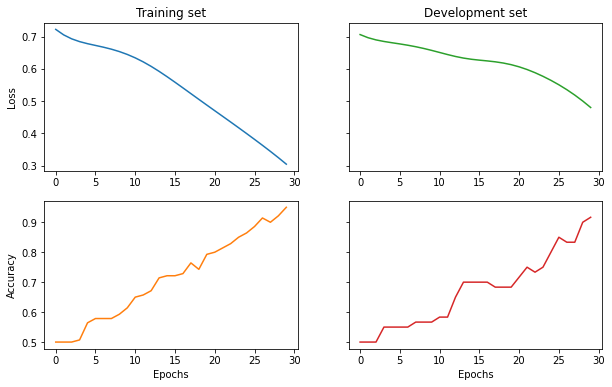

In [13]:
import matplotlib.pyplot as plt

fig1, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharey='row', figsize=(10, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

# print test accuracy
test_acc = accuracy(model(test_circuits), torch.tensor(test_labels))
print('Test accuracy:', test_acc.item())

# Step 3. Parameterisation Quantum case
量子の場合、ライブラリにはIQPAnsatzクラスが装備されており、図を標準的なIQP回路に変換することができる。

In [1]:
from lambeq import BobcatParser

sentence = 'John walks in the park'

# Get a string diagram
parser = BobcatParser(verbose='text')
diagram = parser.sentence2diagram(sentence)

/opt/conda/lib/python3.9/site-packages/lambeq/ccg2discocat/ccg_parser.py:23: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


IQPAnsatzのインスタンスを作成するには、図に出現するすべてのタイプ（この場合は名詞タイプと文タイプ）について、量子ビットの数を定義する必要がある。

以下のコードでは、名詞型に1量子ビット、文型に1量子ビットを割り当てて回路を生成する。IQP層の数(n_layers)は2に設定する。

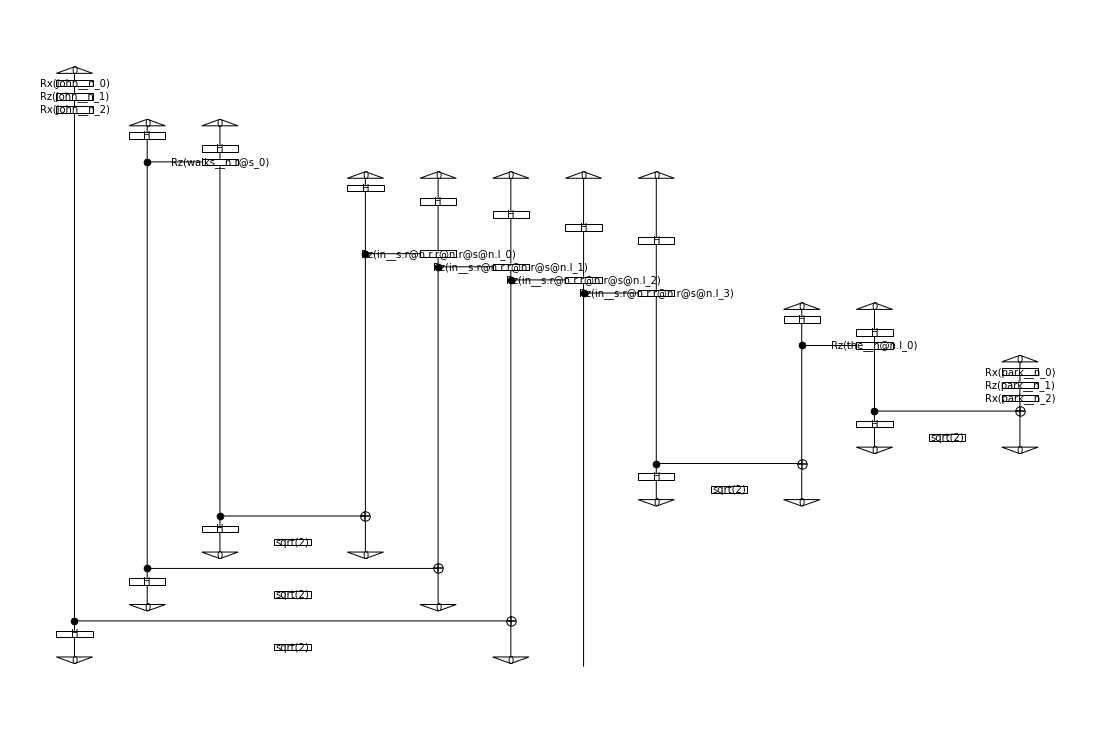

In [2]:
from lambeq import AtomicType, IQPAnsatz

# Define atomic types
N = AtomicType.NOUN
S = AtomicType.SENTENCE

# Convert string diagram to quantum circuit
ansatz = IQPAnsatz({N: 1, S: 1}, n_layers=2)
discopy_circuit = ansatz(diagram)
discopy_circuit.draw(figsize=(15,10))

pytketフォーマットへの変換は非常に簡単。

In [3]:
from pytket.circuit.display import render_circuit_jupyter

tket_circuit = discopy_circuit.to_tk()

render_circuit_jupyter(tket_circuit)

# Step 4: Training Quantum case
以下では、関係代名詞の分類タスクを解くために、lambeqモデルを学習する。
目標は、名詞句が主格の関係代名詞句または目的格の関係代名詞句のどちらを含むかを予測すること。

IQPAnsatzを用いて、図を量子回路に変換する。

バックエンドとしてtketを使用する。

古典と量子の場合の違いはわずかであることが分かる。

# Preparation
NumPyをインポートし、学習用ハイパーパラメータを指定する。

In [1]:
# Training Quantum case
import numpy as np

BATCH_SIZE = 30
EPOCHS = 10
SEED = 2

# Input data
トレーニングデータの読み込み（関係代名詞目的格：(1,0), 関係代名詞主格:(0,1)）

In [2]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('./Lambeq/examples/datasets/rp_train_data.txt')
val_labels, val_data = read_data('./Lambeq/examples/datasets/rp_test_data.txt')

In [3]:
train_data[1],train_data[40]

('organization that team join .', 'room that school include .')

In [4]:
train_labels[0],train_labels[40]

([1, 0], [1, 0])

# Creating and parameterising diagrams
文から図に変換

In [5]:
from lambeq import BobcatParser

parser = BobcatParser(root_cats=('NP', 'N'), verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)

/opt/conda/lib/python3.9/site-packages/lambeq/ccg2discocat/ccg_parser.py:23: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


# Filter and simplify diagrams
normal_form()を呼び出して図を簡略化し、解析できなかった図を省く。

In [6]:
train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, train_labels)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, val_labels)
    if diagram is not None
]

文の目的格の関係代名詞がある場合の図

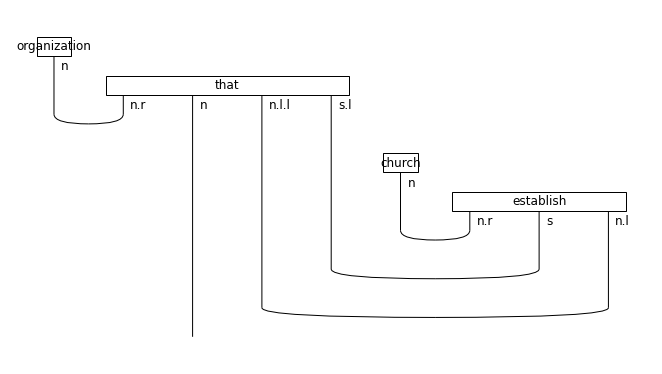

In [7]:
train_diagrams[0].draw(figsize=(9, 5), fontsize=12)

文の主格の関係代名詞がある場合の図

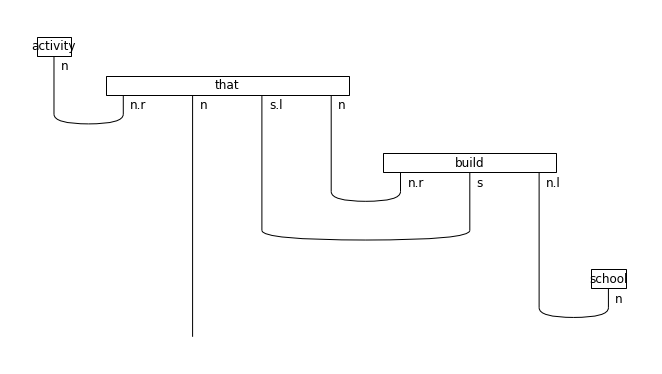

In [8]:
train_diagrams[-1].draw(figsize=(9, 5), fontsize=12)

量子コンピュータで実験を行うためには、図に量子Ansatzを適用する必要がある。
名詞句を扱うタスクなので、名詞（n）を1量子ビットで表現し、文（s）を0量子ビット(破棄)したIQPAnsatzを用いる。

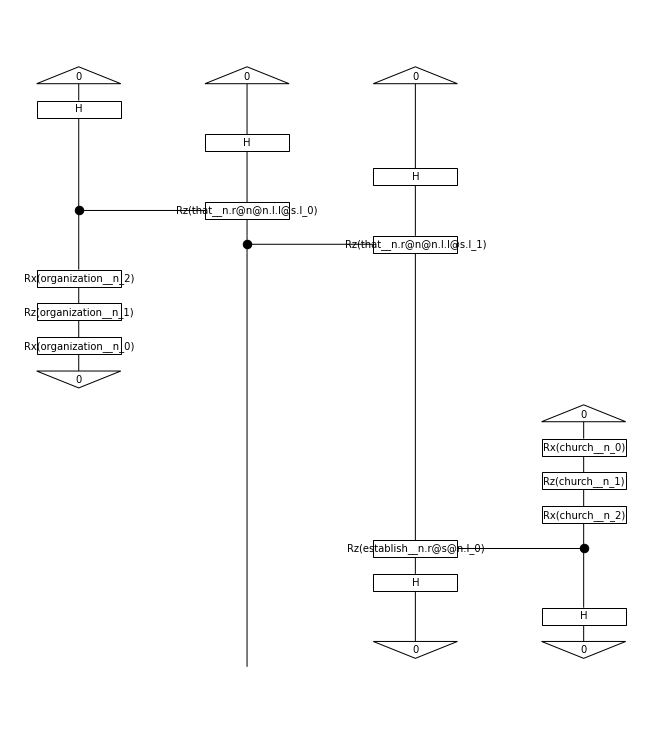

In [9]:
from lambeq import AtomicType, IQPAnsatz, remove_cups

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 0},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]

train_circuits[0].draw(figsize=(9, 10))

図をパラメータ化する前に、カップを削除する。これによってモデルの計算効率を向上させることができる。

この図のカップ除去の効果は以下のようになる。

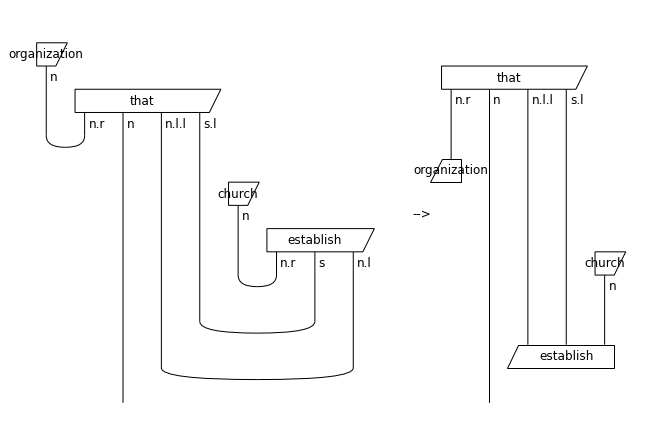

In [10]:
from discopy.drawing import equation

original_diagram = train_diagrams[0]
removed_cups_diagram = remove_cups(original_diagram)

equation(original_diagram, removed_cups_diagram, symbol='-->', figsize=(9, 6), asymmetry=0.3, fontsize=12)

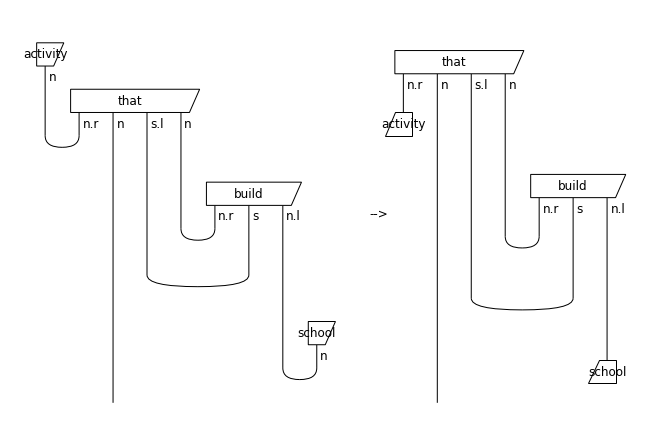

In [11]:
from discopy.drawing import equation

original_diagram1 = train_diagrams[-1]
removed_cups_diagram1 = remove_cups(original_diagram1)

equation(original_diagram1, removed_cups_diagram1, symbol='-->', figsize=(9, 6), asymmetry=0.3, fontsize=12)

TketModel.from_diagrams()に全ての図を渡すことで初期値を設定する。
TketModelは、バックエンドの設定を必要する。
この設定には、バックエンド、コンパイル、ショットの各エントリーが含まれている必要がある。
バックエンドはpytket-extensionsで提供されます。
この例では、qiskitのAerBackendを使用し、8192ショットを使用しています。

In [21]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits + val_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

# Define loss and the evaluation metric
We use standard binary cross-entropy as the loss. Optionally, we can provide a dictionary of callable evaluation metrics with the signature metric(y_hat, y).
損失として二値交差エントロピーを使用する。
オプションとして、以下のように評価指標を設定することが可能。

In [22]:
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}

# Initialise trainer
lambeqでは、量子パイプラインはQuantumTrainerがベースです。
lambeq標準のSPSAオプティマイザを使用します。

これには3つのハイパーパラメータが必要です。
- a: The initial learning rate (decays over time),
- c: The initial parameter shift scaling factor (decays over time),
- A: A stability constant, best choice is approx. 0.01 * number of training steps.

In [23]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

# Creating the datasets
lambeqにはDatasetのバッチ処理とデータのシャッフルが容易に行えます。 シャッフルはデフォルトで有効になっており、バッチサイズにデータセットの長さが設定されます。

In [24]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

# Train the model
データセットをtrainerのfit()メソッドに渡して、学習を開始。

In [25]:
trainer.fit(train_dataset, val_dataset, evaluation_step=1, logging_step=1)

Epoch 1:   train/loss: 1.6114   valid/loss: 1.2585   train/acc: 0.5441   valid/acc: 0.6129
Epoch 2:   train/loss: 1.7214   valid/loss: 1.3340   train/acc: 0.5735   valid/acc: 0.7419
Epoch 3:   train/loss: 1.0257   valid/loss: 1.4124   train/acc: 0.6471   valid/acc: 0.7258
Epoch 4:   train/loss: 0.9448   valid/loss: 0.6549   train/acc: 0.6765   valid/acc: 0.6935
Epoch 5:   train/loss: 1.0662   valid/loss: 0.5104   train/acc: 0.5735   valid/acc: 0.6774
Epoch 6:   train/loss: 1.5359   valid/loss: 0.5060   train/acc: 0.4485   valid/acc: 0.7581
Epoch 7:   train/loss: 0.8367   valid/loss: 0.6011   train/acc: 0.7206   valid/acc: 0.6613
Epoch 8:   train/loss: 1.3819   valid/loss: 0.6544   train/acc: 0.6912   valid/acc: 0.5645
Epoch 9:   train/loss: 0.8200   valid/loss: 1.1419   train/acc: 0.6765   valid/acc: 0.6452
Epoch 10:  train/loss: 0.8339   valid/loss: 0.6703   train/acc: 0.7206   valid/acc: 0.6774

Training completed!


# Show results
結果を可視化し、テストデータでモデルを評価。

Validation accuracy: 0.6451612903225806


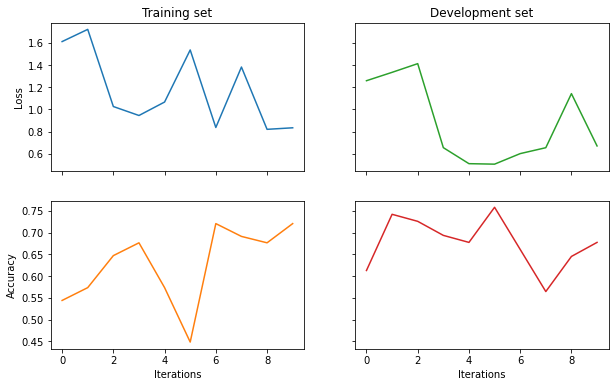

In [26]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
#ax_tl.plot(trainer.train_epoch_costs[::10], color=next(colours))
#ax_bl.plot(trainer.train_results['acc'][::10], color=next(colours))
#ax_tr.plot(trainer.val_costs[::10], color=next(colours))
#ax_br.plot(trainer.val_results['acc'][::10], color=next(colours))
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

# print test accuracy
test_acc = acc(model(val_circuits), val_labels)
print('Validation accuracy:', test_acc.item())